In [1]:
import sys
sys.path.append('../xmen/benchmarks')

# Entity Simplification with OpenAI / GPT-4

In [2]:
from pathlib import Path
import pandas as pd
import datasets
import numpy as np

In [3]:
base_path = Path.home() / '.cache' / 'xmen' / 'symptemist'

In [4]:
import dataloaders
dataset = dataloaders.load_symptemist()[0]

/dhc/home/florian.borchert/conda3/envs/xmen100/lib/python3.10/site-packages/datasets/load.py:929: FutureWarning: The repository for symptemist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /dhc/home/florian.borchert/workspace/biomedical/bigbio/hub/hub_repos/symptemist/symptemist.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/744 [00:00<?, ? examples/s]

Filter:   0%|          | 0/744 [00:00<?, ? examples/s]

In [5]:
from xmen import load_kb
kb = load_kb(base_path / 'symptemist.jsonl')

In [7]:
from xmen.evaluation import error_analysis, evaluate, evaluate_at_k

In [9]:
from xmen.linkers import default_ensemble
linker = default_ensemble(base_path / 'index', cuda=False)

[05/06/24 22:33:23] INFO     Loading hierarchical faiss index                                ]8;id=959380;file:///dhc/home/florian.borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=444420;file:///dhc/home/florian.borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py#153\153]8;;\

                    INFO     Loading index from                                                 ]8;id=642947;file:///dhc/home/florian.borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=781970;file:///dhc/home/florian.borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             /dhc/home/florian.borchert/.cache/xmen/symptemist/index/sapbert/em                    
                             bed_faiss_hier.pickle                                                                 

[05/06/24 22:33:40] INFO     Loaded index of type <class 'faiss.swigfaiss_avx2.IndexHNSWFlat'>  ]8;id=670026;file:///dhc/home/florian.borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=57764;file:///dhc/home/florian.borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             and size 1079623                                                                      

In [10]:
SYMPTEMIST_FEW_SHOT_EXAMPLES = [
    ("afebril", "temperatura corporal normal"),
    ("induración de la vaginal testicular", "trastorno de testículo"),
    ("formaciones mamelonadas en su interior a nivel de lóbulo superior", "lesión de pulmón"),
    ("disnea", "disnea"),
]

In [11]:
def count_differences(simplified, original):
    cnt_all = 0
    cnt_diff = 0
    for ds, do in zip(simplified, original):
        for es, eo in zip(ds['entities'], do['entities']):
            cnt_all += 1
            if es['text'] != eo['text']:
                cnt_diff +=1
    return cnt_diff, cnt_all

In [12]:
MODEL = 'gpt-4-0125-preview'
# Pre-computed for SympTEMIST to save API calls
table_file = 'lookup_gpt-4-0125-preview_20240214-205237_prompt1.pkl'
prompt = SYMPTEMIST_FEW_SHOT_EXAMPLES

lookup_table = {}

In [13]:
import pickle
lookup_table = pickle.load(open(table_file, 'rb')) 

In [14]:
from xmen.data.simplification import GPTSimplifier, EntitySimplification, SimplifierWrapper

In [20]:
text_simplifier = GPTSimplifier(
    model=MODEL, 
    open_ai_api_key="insert_api_key", 
    fixed_few_shot_examples = prompt,
    table=lookup_table
)

In [21]:
simplifier = EntitySimplification(text_simplifier, set_long_form=True)

In [22]:
print(text_simplifier.prompt_template.format('aumento de densidad en lóbulo inferior'))

Your task is to simplify expressions, such that the simplified version is more suitable for looking up concepts in a medical terminology. If the input is already simple enough, just return the input. 

Here are some examples:
Input: ```afebril```
Simplified: ```temperatura corporal normal```

Input: ```induración de la vaginal testicular```
Simplified: ```trastorno de testículo```

Input: ```formaciones mamelonadas en su interior a nivel de lóbulo superior```
Simplified: ```lesión de pulmón```

Input: ```disnea```
Simplified: ```disnea```

Input: ```aumento de densidad en lóbulo inferior```
Simplified:


In [23]:
text_simplifier.simplify('aumento de densidad en lóbulo inferior')

'lesión de pulmón'

# Generate Candidates

In [ ]:
candidates = linker.predict_batch(dataset, top_k=64, batch_size=128)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

In [25]:
_ = evaluate_at_k(dataset['train'], candidates['train'])

Recall@1 0.43913488236153736
Recall@2 0.5608651176384627
Recall@4 0.6222417068537192
Recall@8 0.6780651760923572
Recall@16 0.7217594622241706
Recall@32 0.7562472599736958
Recall@64 0.7838667251205611


In [26]:
_ = evaluate_at_k(dataset['validation'], candidates['validation'])

Recall@1 0.4647592463363573
Recall@2 0.5771109560362875
Recall@4 0.6420097697138869
Recall@8 0.6929518492672715
Recall@16 0.7257501744591766
Recall@32 0.7557571528262387
Recall@64 0.7808792742498255


In [27]:
_ = evaluate_at_k(dataset['test'], candidates['test'])

Recall@1 0.4474885844748858
Recall@2 0.5605900948366702
Recall@4 0.6199508254302775
Recall@8 0.6663154197400772
Recall@16 0.7003863716192483
Recall@32 0.7319985950122937
Recall@64 0.7643133122585177


In [28]:
simplified_ds = simplifier.transform_batch(candidates)
simplified_candidates = linker.predict_batch(simplified_ds, top_k=64, batch_size=128)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

# Determine Optimal Cutoff

In [29]:
SPLIT = 'train'
eval_candidates = candidates[SPLIT]
eval_ds = dataset[SPLIT]
eval_simplified_ds = simplified_candidates[SPLIT]

def select_candidates(d, idx, filter_fn=lambda e: True):
    result = []
    for ei, ec in zip(d['entities'], eval_candidates[idx]['entities']):
        if filter_fn(ec):
            result.append(ec)
        else:
            result.append(ei)
    return { 'entities' : result }

In [30]:
baseline = evaluate_at_k(eval_ds, eval_candidates, silent=True)

In [31]:
cutoff_eval = []

for cutoff in np.arange(0.55, 1.05, 0.05):
    print(cutoff)
    fn = lambda e: e['normalized'][0]['score'] >= cutoff
    best_candidates = eval_simplified_ds.map(lambda d, i: select_candidates(d, i, fn), with_indices=True)
    diffs = count_differences(best_candidates, eval_candidates)
    print(diffs)
    eval_res = evaluate_at_k(eval_ds, best_candidates, silent=True)
    cutoff_eval_i = {'cutoff' : cutoff, 'num_changed' : diffs[0], 'num_all' : diffs[1]}
    for i, es in eval_res.items():
        cutoff_eval_i[i] = es['strict']['recall']
    cutoff_eval.append(cutoff_eval_i)

0.55


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(11, 6843)
0.6000000000000001


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(104, 6843)
0.6500000000000001


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(466, 6843)
0.7000000000000002


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(1089, 6843)
0.7500000000000002


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(1872, 6843)
0.8000000000000003


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(2585, 6843)
0.8500000000000003


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(3239, 6843)
0.9000000000000004


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(3864, 6843)
0.9500000000000004


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(4357, 6843)
1.0000000000000004


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

(5841, 6843)


In [32]:
cutoff_eval = pd.DataFrame(cutoff_eval).round(3)

In [33]:
cutoff_eval

,cutoff,num_changed,num_all,1,2,4,8,16,32,64
0,0.55,11,6843,0.439,0.561,0.623,0.678,0.722,0.757,0.784
1,0.60,104,6843,0.439,0.561,0.623,0.678,0.722,0.756,0.784
2,0.65,466,6843,0.442,0.565,0.626,0.681,0.725,0.760,0.789
3,0.70,1089,6843,0.448,0.571,0.634,0.688,0.733,0.768,0.796
4,0.75,1872,6843,0.452,0.577,0.639,0.693,0.737,0.772,0.802
5,0.80,2585,6843,0.453,0.576,0.638,0.691,0.738,0.772,0.802
6,0.85,3239,6843,0.453,0.575,0.638,0.693,0.746,0.780,0.811
7,0.90,3864,6843,0.446,0.568,0.635,0.690,0.744,0.781,0.811
8,0.95,4357,6843,0.433,0.556,0.626,0.686,0.742,0.780,0.810
9,1.00,5841,6843,0.428,0.551,0.622,0.685,0.741,0.780,0.810


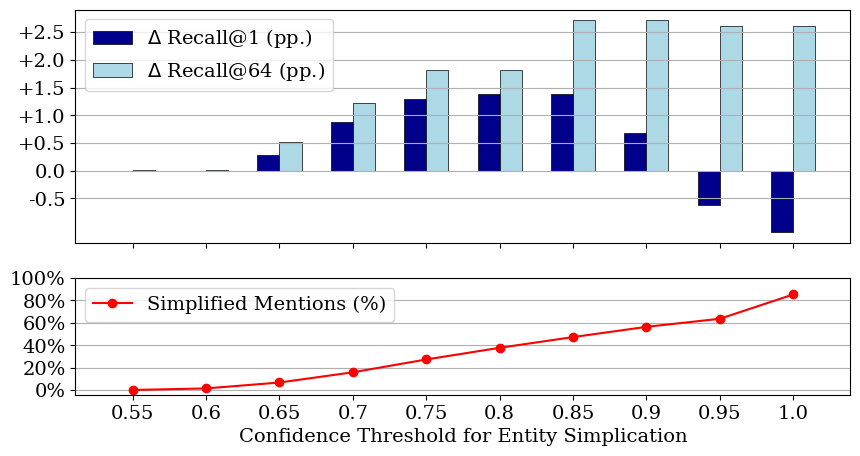

In [50]:
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 14, 'font.family' : 'serif'})

fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]}, squeeze=True)

ax1 = axs[0]

x_range = np.arange(0, len(cutoff_eval))
width = 0.3       

ax1.bar(x_range - 0.5 * width, 
        (cutoff_eval.set_index('cutoff')[1] - baseline[1]['strict']['recall']).values, 
        width, color='darkblue', linewidth=0.5, edgecolor='black', label='$\Delta$ Recall@1 (pp.)')
ax1.bar(x_range + 0.5 * width, 
        (cutoff_eval.set_index('cutoff')[64] - baseline[64]['strict']['recall']).values, 
        width, color='lightblue', linewidth=0.5, edgecolor='black', label='$\Delta$ Recall@64 (pp.)')

ax1.grid(axis='y')
ax1.set_yticks(np.arange(-0.005, 0.03, 0.005))
ax1.set_yticklabels([f'+{t * 100:.1f}' if t > 0 else f'{t * 100:.1f}' for t in ax1.get_yticks()])

ax1.set_xticks(x_range)
ax1.set_xticklabels(cutoff_eval.cutoff.values)

ax0 = axs[1]
ax0.grid(axis='y')
ax0.plot(x_range, cutoff_eval.num_changed / cutoff_eval.num_all, color='red', label='Simplified Mentions (%)', marker='o')
ax0.set_yticks(np.arange(0,1.02,0.2))
ax0.set_yticklabels([f"{int(t * 100)}%" if t >= 0 and t <=1 else "" for t in ax0.get_yticks()])

ax0.set_xlabel('Confidence Threshold for Entity Simplication')
ax0.legend()

ax0.set_xticks(x_range)
ax0.set_xticklabels(cutoff_eval.cutoff.values)

ax1.legend()

#plt.savefig('diff_cutoff.png', dpi=1200, bbox_inches='tight')

plt.show()

In [35]:
best_cutoff = 0.85

In [36]:
# we use a SimplifierWrapper so that the original spans can be restored after candidate generatio
simplifier_wrapper = SimplifierWrapper(
    linker,
    text_simplifier, 
    filter_fn=lambda c: c['normalized'][0]['score'] < best_cutoff, 
    set_long_form=True
)
simplified_candidates_cutoff = simplifier_wrapper.predict_batch(candidates, top_k=64, batch_size=128)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

In [37]:
print(count_differences(simplified_candidates_cutoff['train'], dataset['train']))
print(count_differences(simplified_candidates_cutoff['validation'], dataset['validation']))
print(count_differences(simplified_candidates_cutoff['test'], dataset['test']))

(0, 6843)
(0, 1433)
(0, 2848)


In [38]:
_ = evaluate_at_k(dataset['validation'], simplified_candidates_cutoff['validation'])

Recall@1 0.4842986741102582
Recall@2 0.5917655268667132
Recall@4 0.6559665038381018
Recall@8 0.7069085833914864
Recall@16 0.7522679692951849
Recall@32 0.776692254012561
Recall@64 0.8060013956734124


In [39]:
_ = evaluate_at_k(dataset['test'], simplified_candidates_cutoff['test'])

Recall@1 0.4611872146118721
Recall@2 0.5749912188268352
Recall@4 0.6424306287319986
Recall@8 0.6870389884088515
Recall@16 0.7274323849666315
Recall@32 0.761854583772392
Recall@64 0.7924130663856691


# Save

In [40]:
simplified_candidates_cutoff.save_to_disk('candidates_simplified_cutoff')

Saving the dataset (0/1 shards):   0%|          | 0/608 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/246 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/136 [00:00<?, ? examples/s]

# Analysis

In [41]:
from xmen.evaluation import error_analysis, evaluate_at_k

In [42]:
_ = evaluate_at_k(dataset['test'], candidates['test'])

Recall@1 0.4474885844748858
Recall@2 0.5605900948366702
Recall@4 0.6199508254302775
Recall@8 0.6663154197400772
Recall@16 0.7003863716192483
Recall@32 0.7319985950122937
Recall@64 0.7643133122585177


In [43]:
_ = evaluate_at_k(dataset['test'], simplified_candidates_cutoff['test'])

Recall@1 0.4611872146118721
Recall@2 0.5749912188268352
Recall@4 0.6424306287319986
Recall@8 0.6870389884088515
Recall@16 0.7274323849666315
Recall@32 0.761854583772392
Recall@64 0.7924130663856691


In [44]:
simplified_ds = simplifier.transform_batch(dataset)

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

In [399]:
ea_before_simple_test = error_analysis(dataset['test'], candidates['test'])
ea_after_simple_test = error_analysis(simplified_ds['test'], simplified_candidates_cutoff['test'])

In [403]:
ea_after_no_thresh_test = error_analysis(simplified_ds['test'], simplified_candidates['test'])

In [418]:
SPLIT = 'test'
eval_candidates = candidates[SPLIT]
eval_ds = dataset[SPLIT]
eval_simplified_ds = simplified_candidates[SPLIT]

def select_candidates(d, idx, filter_fn=lambda e: True):
    result = []
    for ei, ec in zip(d['entities'], eval_candidates[idx]['entities']):
        if filter_fn(ec):
            result.append(ec)
        else:
            result.append(ei)
    return { 'entities' : result }

In [419]:
fn = lambda e: e['normalized'][0]['score'] >= best_cutoff
best_candidates = eval_simplified_ds.map(lambda d, i: select_candidates(d, i, fn), with_indices=True)

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

In [448]:
def get_len(t):
    return len(t.split(' '))

def get_stats(ea_df, name, ds):
    res = {}
    res['name'] = name
    word_lens = pd.Series([get_len(e['text'][0]) for d in ds for e in d['entities']])
    res['max_length'] = int(word_lens.max())
    res['mean_length'] = word_lens.mean().round(2)
    res['recall_1'] = (ea_df.pred_index == 0).sum() / len(ea_df)
    res['recall_64'] = (ea_df.pred_index >= 0).sum() / len(ea_df)
    res['mean_score'] = ea_df.pred_top_score.mean()
    for i in np.linspace(0.5, 1.0, 6):
        begin, end = i, i + 0.1
        sub_ea = ea_df[(ea_df.pred_top_score >= begin) & (ea_df.pred_top_score < end)]
        prefix = f"{begin}-{end}"
        res[f'{prefix}_len'] = len(sub_ea)
        res[f'{prefix}_recall_1'] = (sub_ea.pred_index == 0).sum() / len(sub_ea)
        res[f'{prefix}_recall_64'] = (sub_ea.pred_index >= 0).sum() / len(sub_ea)
    return res

In [463]:
df = pd.DataFrame([
    get_stats(ea_before_simple_test, 'no_simpl', candidates['test']),
    get_stats(ea_after_simple_test, 'simpl_thresh', best_candidates),
    get_stats(ea_after_no_thresh_test, 'simpl_no_thresh', simplified_ds['test']),
]).set_index('name').T
df['delta'] = df.simpl_thresh - df.no_simpl
df.round(3)[['no_simpl', 'simpl_thresh', 'delta', 'simpl_no_thresh']]

name,no_simpl,simpl_thresh,delta,simpl_no_thresh
max_length,23.000,13.000,-10.000,13.000
mean_length,3.630,2.610,-1.020,2.830
recall_1,0.447,0.461,0.014,0.431
recall_64,0.764,0.792,0.028,0.792
mean_score,0.848,0.833,-0.015,0.815
0.5-0.6_len,37.000,83.000,46.000,83.000
0.5-0.6_recall_1,0.027,0.048,0.021,0.048
0.5-0.6_recall_64,0.243,0.241,-0.002,0.241
0.6-0.7_len,444.000,616.000,172.000,639.000
0.6-0.7_recall_1,0.065,0.096,0.030,0.095


In [313]:
ea_after_simple[(ea_before_simpl.pred_index == -1) & (ea_after_simple.pred_index == 0)].head(5)

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_type,pred_start,pred_end,pred_text,pred_type,ner_match_type,gold_concept,pred_index,pred_index_score,pred_top,pred_top_score,corpus_id,document_id
97,2,False,2182,2201,[enfermedad pulmonar],SINTOMA,2182,2201,[patrón intersticial],SINTOMA,tp,"{'db_id': '233703007', 'db_name': 'SNOMED_CT'}",0,0.729934,233703007,0.729934,symptemist_linking_complete_bigbio_kb,es-S0212-71992007000600008-1
115,2,False,4897,4924,[enfermedad pulmonar],SINTOMA,4897,4924,[patrón intersticial nodular],SINTOMA,tp,"{'db_id': '233703007', 'db_name': 'SNOMED_CT'}",0,0.680239,233703007,0.680239,symptemist_linking_complete_bigbio_kb,es-S0212-71992007000600008-1
171,3,False,913,942,[ritmo cardíaco normal],SINTOMA,913,942,[Auscultación cardiaca rítmica],SINTOMA,tp,"{'db_id': '64730000', 'db_name': 'SNOMED_CT'}",0,0.728067,64730000,0.728067,symptemist_linking_complete_bigbio_kb,es-S0212-71992006000700009-1
236,2,False,2032,2047,[perfusión normal],SINTOMA,2032,2047,[normoperfundido],SINTOMA,tp,"{'db_id': '1137685003', 'db_name': 'SNOMED_CT'}",0,0.762895,1137685003,0.762895,symptemist_linking_complete_bigbio_kb,es-S0212-71992006000200006-1
324,4,False,370,391,[examen de recto normal],SINTOMA,370,391,[tacto rectal negativo],SINTOMA,tp,"{'db_id': '274765004', 'db_name': 'SNOMED_CT'}",0,0.763149,274765004,0.763149,symptemist_linking_complete_bigbio_kb,es-S1130-01082005001100014-1


In [464]:
both_correct = (ea_before_simpl.pred_index == 0) & (ea_after_simple.pred_index == 0)
print(ea_before_simpl[both_correct]._word_len.mean(), ea_after_simple[both_correct]._word_len.mean())

2.294853466761973 2.5761258041458186


In [465]:
better_recall = (ea_before_simpl.pred_index == -1) & (ea_after_simple.pred_index >= 0)
print(ea_before_simpl[better_recall]._word_len.mean(), ea_after_simple[better_recall]._word_len.mean())

4.992207792207792 3.3506493506493507


In [466]:
better_recall_1 = (ea_before_simpl.pred_index == -1) & (ea_after_simple.pred_index == 0)
print(ea_before_simpl[better_recall_1]._word_len.mean(), ea_after_simple[better_recall_1]._word_len.mean())

3.5660377358490565 3.2830188679245285


In [467]:
ea_after_simple[(ea_before_simpl.pred_index == -1) & (ea_after_simple.pred_index == 0)]._word_len.mean()

3.2830188679245285

In [468]:
ea_after_simple[(ea_before_simpl.pred_index == -1) & (ea_after_simple.pred_index == 0)]._word_len.mean()

3.2830188679245285

## Error Analysis by Mention Length

In [469]:
index = []
labels = []
match_any = []
match_lost = []
better_ranking = []
worse_ranking = []
n_candidates = []

end = 10

def get_new_candidates(i):
    return ea_after_simple[(ea_before_simpl._word_len == i) & (ea_before_simpl.pred_index == -1) & (ea_after_simple.pred_index != -1)]

def get_better_ranking(i):
    return ea_after_simple[(ea_before_simpl._word_len == i) & (ea_after_simple.pred_index != -1) & (ea_after_simple.pred_index < ea_before_simpl.pred_index)]

def get_worse_ranking(i):
    return ea_after_simple[(ea_before_simpl._word_len == i) & (ea_before_simpl.pred_index != -1) & (ea_after_simple.pred_index > ea_before_simpl.pred_index)]

def get_lost_candidates(i):
    return ea_after_simple[(ea_before_simpl._word_len == i) & (ea_before_simpl.pred_index != -1) & (ea_after_simple.pred_index == -1)]

def get_n_candidates(i):
    return ea_after_simple[(ea_before_simpl._word_len == i)]

for i in range(1, end + 1):
    n_candidates_i = get_n_candidates(i)
    eaany = get_new_candidates(i)
    eabetter = get_better_ranking(i)
    ealost = get_lost_candidates(i)
    eaworse = get_worse_ranking(i)
    
    n_candidates.append(len(n_candidates_i))
    index.append(i)
    labels.append(str(i))
    match_any.append(len(eaany))
    better_ranking.append(len(eabetter))
    match_lost.append(-len(ealost))
    worse_ranking.append(-len(eaworse))
    
labels.append(str(f'>{ i }'))

i += 1

n_candidates_i = get_n_candidates(i)
eaany = get_new_candidates(i)
eabetter = get_better_ranking(i)
ealost = get_lost_candidates(i)
eaworse = get_worse_ranking(i)

n_candidates.append(len(n_candidates_i))
index.append(i)
match_any.append(len(eaany))
better_ranking.append(len(eabetter))
match_lost.append(-len(ealost))
worse_ranking.append(-len(eaworse))

In [470]:
def get_rel(m):
    return [mi / ci for mi, ci in zip(m, n_candidates)]

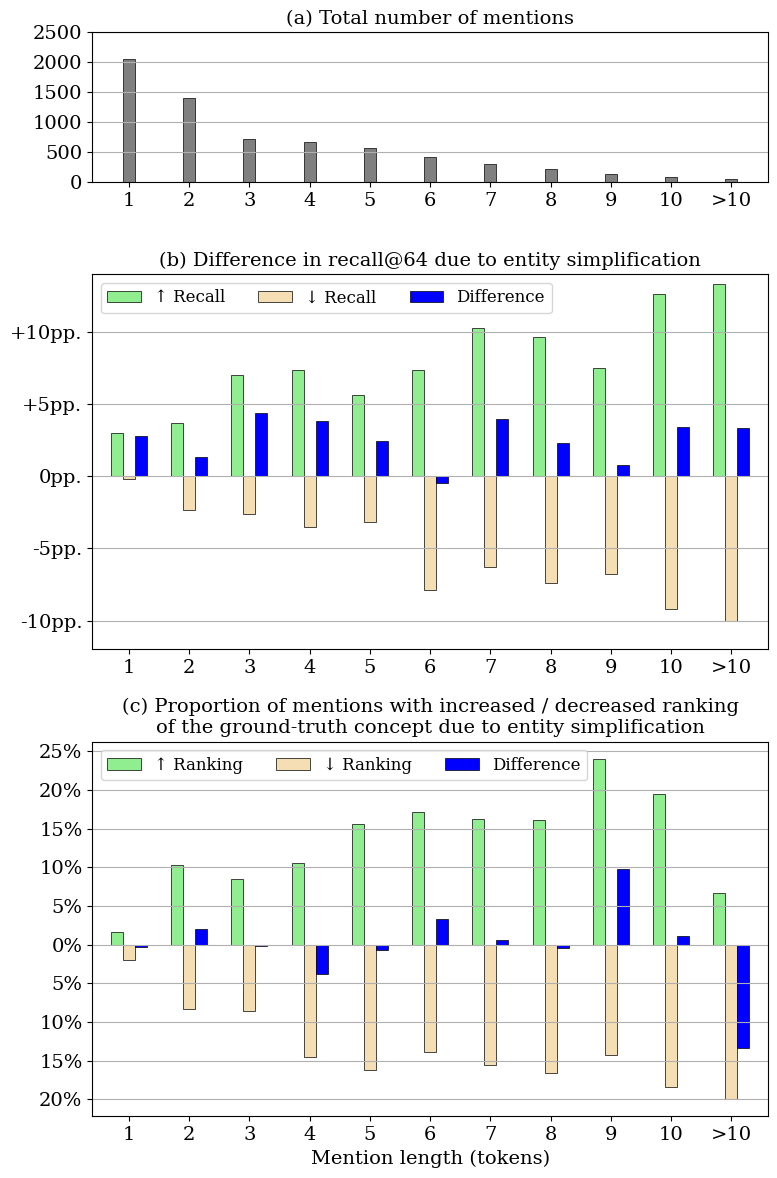

In [471]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager


fig, axs = plt.subplots(3, 1, figsize=(8,12), gridspec_kw={'height_ratios': [0.4, 1, 1]})
font_size_lg = 14
font_size_sm = 12

matplotlib.rcParams.update({'font.size': font_size_lg, 'font.family' : 'serif'})

width = 0.2

ax0 = axs[0]
ax0.bar(np.array(index), n_candidates, width=width, label='No. Mentions', color='grey', edgecolor='black', linewidth=0.5)
ax0.grid(axis='y')
ax0.set_title('(a) Total number of mentions', size=font_size_lg)
ax0.set_yticks(range(0,3000,500))

ax1 = axs[1]

ax1.grid(axis='y')

#ax.bar(np.array(index) - width, match_0, width=width, label='')
ax1.bar(np.array(index) - width, get_rel(match_any), width=width, label='↑ Recall', color='lightgreen', edgecolor='black', linewidth=0.5)
ax1.bar(np.array(index), get_rel(match_lost), width=width, label='↓ Recall', color='wheat', edgecolor='black', linewidth=0.5)
ax1.bar(np.array(index) + width, get_rel(np.array(match_any) + np.array(match_lost)), width=width, label='Difference', color='blue', edgecolor='black', linewidth=0.5)

y_range = np.arange(-0.1, 0.18, 0.05)
ax1.set_yticks(y_range)
ax1.set_yticklabels([f'{"+" if i > 0 else ""}{round(i * 100)}pp.' for i in y_range])
ax1.set_ylim(-0.12,0.14)
ax1.set_title('(b) Difference in recall@64 due to entity simplification', size=font_size_lg)
ax1.legend(loc='upper left', 
           ncol=3, fontsize=font_size_sm)    

ax2 = axs[2]
    
ax2.bar(np.array(index) - width, get_rel(better_ranking), width=width, label='↑ Ranking', color='lightgreen', edgecolor='black', linewidth=0.5)
ax2.bar(np.array(index), get_rel(worse_ranking), width=width, label='↓ Ranking', color='wheat', edgecolor='black', linewidth=0.5)
ax2.bar(np.array(index) + width, get_rel(np.array(better_ranking) + np.array(worse_ranking)), width=width, label='Difference', color='blue', edgecolor='black', linewidth=0.5)
    
y_range_2 = np.arange(-0.2,0.3,0.05)
ax2.set_yticks(y_range_2)
ax2.set_yticklabels([f'{"" if i > 0 else ""}{abs(round(i * 100))}%' for i in y_range_2])
 
ax2.legend(loc='upper left', ncol=3, fontsize=font_size_sm)
ax2.set_title('(c) Proportion of mentions with increased / decreased ranking\nof the ground-truth concept due to entity simplification', size=font_size_lg)
    
ax2.grid(axis='y')
ax2.set_xlabel('Mention length (tokens)')

for ax in axs:
    ax.set_xlim(axs[0].get_xlim())
    ax.set_xticks(index)
    ax.set_xticklabels(labels)

fig.tight_layout()
    
#plt.savefig('gain_vs_length.png', dpi=1200, bbox_inches='tight')
plt.show()